In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pprint
import numpy as np
import pandas as pd
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
import scanpy as sc

from sklearn.metrics import adjusted_rand_score

import warnings
from numba.core.errors import NumbaDeprecationWarning

from calicost import arg_parse

In [3]:
from sim_analysis import (
    get_config,
    get_sampleid,
    get_best_r_hmrf,
    get_rdrbaf,
    get_true_clones_path,
    get_true_clones,
    get_sim_runs,
    get_numbat_path,
    get_numbat_clones,
    get_starch_clones,
    plot_true_clones,
    get_calico_clones,
    read_gene_loc,
    read_true_gene_cna,
    read_calico_gene_cna,
    read_numbat_gene_cna,
    read_starch_gene_cna,
    compute_gene_F1,
    get_aris, 
    plot_aris,
    get_f1s,
    plot_f1s
)

## Configuration

In [4]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [5]:
pd.set_option('display.max_rows', 10)
plt.rcParams.update({'font.size': 14})
sc.set_figure_params(dpi=120)

In [6]:
! pwd

/Users/mw9568/Work/ragr/sim/calicost_sim


In [7]:
true_dir = "../simulated_data_related"
calico_pure_dir = "../nomixing_calicost_related"
numbat_dir = "../numbat_related"
starch_dir = "../starch_related"

# hg_table_file = "/nfs/turbo/umms-congma1/projects/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt"
hg_table_file = "/Users/mw9568/Work/ragr/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt"

## Preface

Note:
 - min. 100 spots per clone
 - assumes (max.) of 3 clones

In [8]:
config_path = "../nomixing_calicost_related//numcnas1.2_cnasize1e7_ploidy2_random0/configfile0"

config = get_config(config_path)
pprint.pprint(config)

{'bafonly': False,
 'construct_adjacency_method': 'hexagon',
 'construct_adjacency_w': 1.0,
 'filtergenelist_file': '/n/fs/ragr-data/users/congma/references/cellranger_refdata-gex-GRCh38-2020-A/genes/ig_gene_list.txt',
 'filterregion_file': '/n/fs/ragr-data/users/congma/references/cellranger_refdata-gex-GRCh38-2020-A/genes/HLA_regions.bed',
 'fix_BB_dispersion': False,
 'fix_NB_dispersion': False,
 'geneticmap_file': '/u/congma/ragr-data/users/congma/Codes/CalicoST/resources/genetic_map_GRCh38_merged.tab',
 'gmm_random_state': 0,
 'hgtable_file': '/u/congma/ragr-data/users/congma/Codes/STARCH_crazydev/hgTables_hg38_gencode.txt',
 'initialization_method': 'rectangle',
 'logphase_shift': -2.0,
 'max_iter': 30,
 'max_iter_outer': 20,
 'maxspots_pooling': 19,
 'min_avgumi_per_clone': 10,
 'min_percent_expressed_spots': 0.005,
 'min_snpumi_perspot': 50,
 'min_spots_per_clone': 100,
 'n_clones': 3,
 'n_clones_rdr': 2,
 'n_states': 7,
 'nodepotential': 'weighted_sum',
 'nonbalance_bafdist': 1

In [9]:
rdrbaf = get_rdrbaf(config_path, 3, relative_path="../nomixing_calicost_related/", verbose=False)

# NB (# states x # clones TBC).
rdrbaf["new_log_mu"].shape, rdrbaf["new_alphas"].shape, rdrbaf["new_p_binom"].shape, rdrbaf['log_gamma'].shape, rdrbaf['total_llf']

((7, 2), (7, 2), (7, 2), (7, 1750, 2), array(-7479449.7554682))

In [10]:
np.unique(rdrbaf["prev_assignment"]), np.unique(rdrbaf["new_assignment"])

(array([0, 1]), array([0, 1]))

In [11]:
get_true_clones_path(true_dir, (3, 3), "3e7", 2, 0)

'../simulated_data_related/numcnas3.3_cnasize3e7_ploidy2_random0/truth_clone_labels.tsv'

In [12]:
! ls ../simulated_data_related/numcnas3.3_cnasize3e7_ploidy2_random0/truth_clone_labels.tsv

../simulated_data_related/numcnas3.3_cnasize3e7_ploidy2_random0/truth_clone_labels.tsv


In [13]:
true_clones = get_true_clones(true_dir, (3, 3), "3e7", 2, 0)
true_clones

,true_clone,x,y
spot,,,
0,2,0,0
1,2,0,2
2,2,0,4
3,2,0,6
4,2,0,8
...,...,...,...
2995,0,99,51
2996,0,99,53
2997,0,99,55


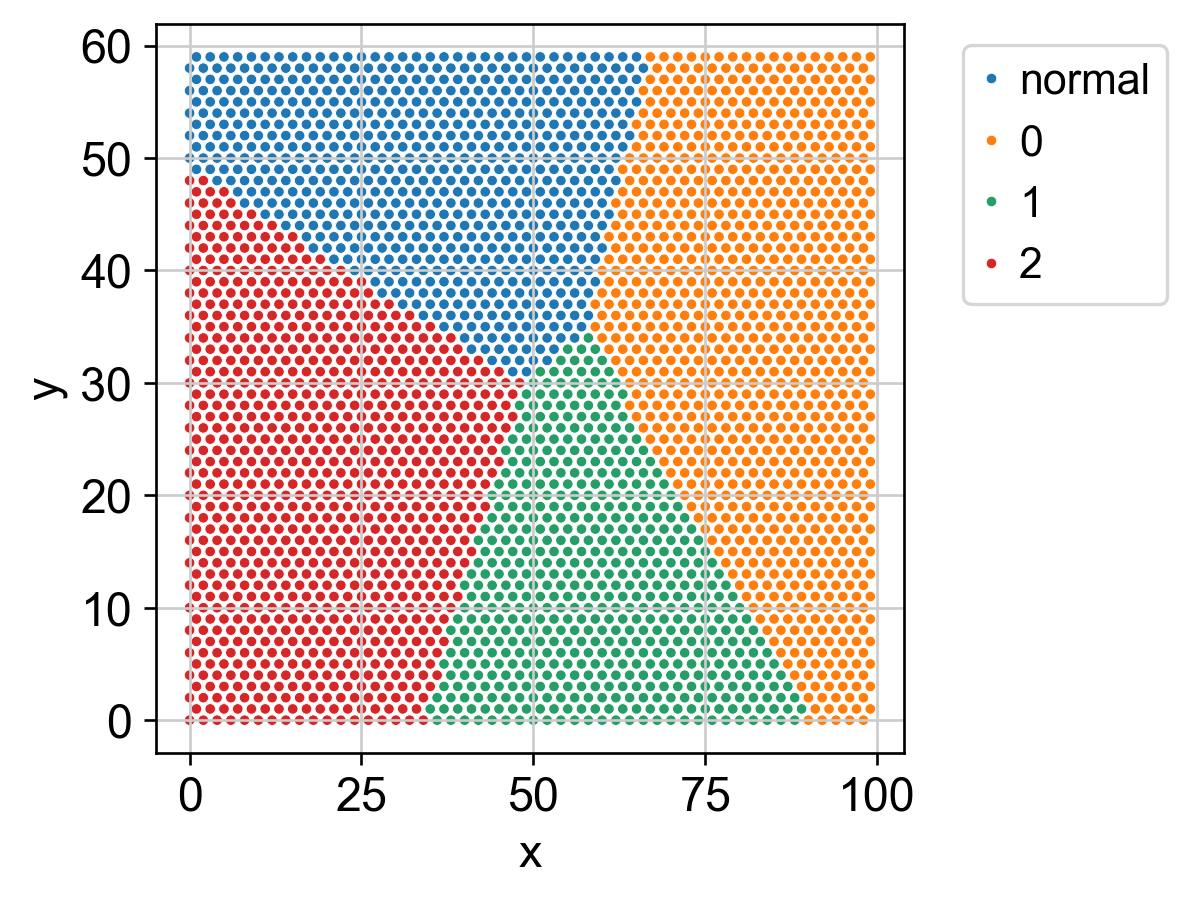

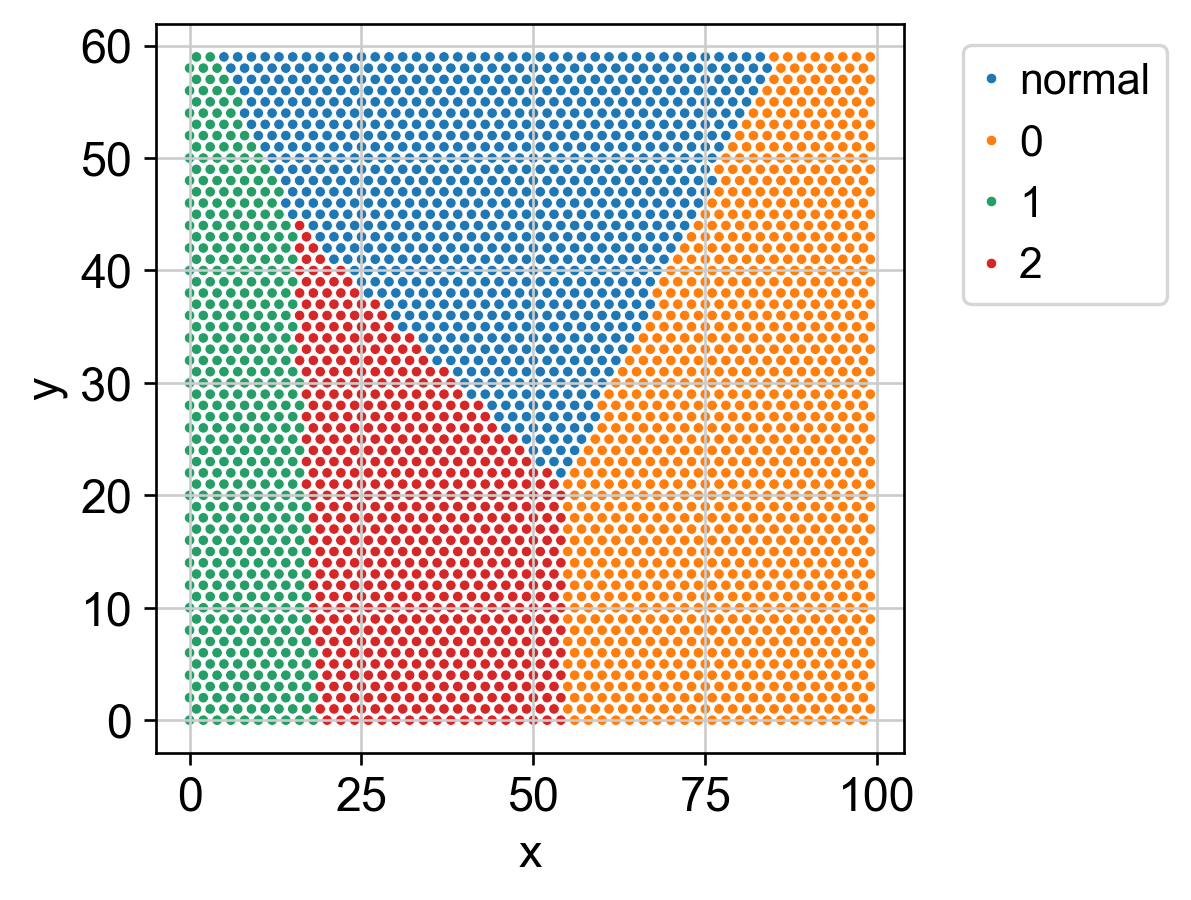

In [14]:
for random_state in range(2):
    plot_true_clones(true_dir, (3, 3), "3e7", 2, random_state)

In [15]:
sim_runs = get_sim_runs()
sim_runs

,n_cnas,cna_size,ploidy,random,sampleid
0,"(1, 2)",1e7,2,0,numcnas1.2_cnasize1e7_ploidy2_random0
1,"(1, 2)",1e7,2,1,numcnas1.2_cnasize1e7_ploidy2_random1
2,"(1, 2)",1e7,2,2,numcnas1.2_cnasize1e7_ploidy2_random2
3,"(1, 2)",1e7,2,3,numcnas1.2_cnasize1e7_ploidy2_random3
4,"(1, 2)",1e7,2,4,numcnas1.2_cnasize1e7_ploidy2_random4
...,...,...,...,...,...
85,"(6, 3)",5e7,2,5,numcnas6.3_cnasize5e7_ploidy2_random5
86,"(6, 3)",5e7,2,6,numcnas6.3_cnasize5e7_ploidy2_random6
87,"(6, 3)",5e7,2,7,numcnas6.3_cnasize5e7_ploidy2_random7
88,"(6, 3)",5e7,2,8,numcnas6.3_cnasize5e7_ploidy2_random8


# Clone identification accuracy

In [16]:
true_clones = get_true_clones(
    true_dir, (3, 3), "3e7", 2, 0
)
true_clones

,true_clone,x,y
spot,,,
0,2,0,0
1,2,0,2
2,2,0,4
3,2,0,6
4,2,0,8
...,...,...,...
2995,0,99,51
2996,0,99,53
2997,0,99,55


In [17]:
calico_clones = get_calico_clones(calico_pure_dir, (3, 3), "3e7", 2, 0)
calico_clones

,est_clone
spot,
0,3
1,3
2,3
3,3
4,3
...,...
2995,1
2996,1
2997,1


In [18]:
numbat_clones = get_numbat_clones(numbat_dir, get_sampleid((3, 3), "3e7", 2, 0))
numbat_clones

,est_clone
spot,
0,2
1,4
10,2
100,2
1000,2
...,...
995,2
996,4
997,1


In [19]:
starch_clones = get_starch_clones(starch_dir, get_sampleid((3, 3), "3e7", 2, 0), true_clones=true_clones)
starch_clones

,est_clone
spot,
0,1
1,1
2,1
3,1
4,1
...,...
2995,1
2996,1
2997,1


In [20]:
clone_aris = get_aris(true_dir, calico_pure_dir, numbat_dir, starch_dir)
clone_aris

,cnas,n_cnas,cna_size,ploidy,random,sample_id,true_clones_path,method,ARI,best_fit_clones_path
0,"(1, 2)",3,10Mb,2,0,numcnas1.2_cnasize1e7_ploidy2_random0,../simulated_data_related/numcnas1.2_cnasize1e...,CalicoST,0.694395,../nomixing_calicost_related/numcnas1.2_cnasiz...
1,"(1, 2)",3,10Mb,2,0,numcnas1.2_cnasize1e7_ploidy2_random0,../simulated_data_related/numcnas1.2_cnasize1e...,Numbat,0.000000,-
2,"(1, 2)",3,10Mb,2,0,numcnas1.2_cnasize1e7_ploidy2_random0,../simulated_data_related/numcnas1.2_cnasize1e...,STARCH,0.585557,../starch_related/numcnas1.2_cnasize1e7_ploidy...
3,"(1, 2)",3,10Mb,2,1,numcnas1.2_cnasize1e7_ploidy2_random1,../simulated_data_related/numcnas1.2_cnasize1e...,CalicoST,0.651819,../nomixing_calicost_related/numcnas1.2_cnasiz...
4,"(1, 2)",3,10Mb,2,1,numcnas1.2_cnasize1e7_ploidy2_random1,../simulated_data_related/numcnas1.2_cnasize1e...,Numbat,0.000000,-
...,...,...,...,...,...,...,...,...,...,...
265,"(6, 3)",9,50Mb,2,8,numcnas6.3_cnasize5e7_ploidy2_random8,../simulated_data_related/numcnas6.3_cnasize5e...,Numbat,0.396501,../numbat_related/numcnas6.3_cnasize5e7_ploidy...
266,"(6, 3)",9,50Mb,2,8,numcnas6.3_cnasize5e7_ploidy2_random8,../simulated_data_related/numcnas6.3_cnasize5e...,STARCH,0.911511,../starch_related/numcnas6.3_cnasize5e7_ploidy...
267,"(6, 3)",9,50Mb,2,9,numcnas6.3_cnasize5e7_ploidy2_random9,../simulated_data_related/numcnas6.3_cnasize5e...,CalicoST,0.942561,../nomixing_calicost_related/numcnas6.3_cnasiz...
268,"(6, 3)",9,50Mb,2,9,numcnas6.3_cnasize5e7_ploidy2_random9,../simulated_data_related/numcnas6.3_cnasize5e...,Numbat,0.848603,../numbat_related/numcnas6.3_cnasize5e7_ploidy...


/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:652: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


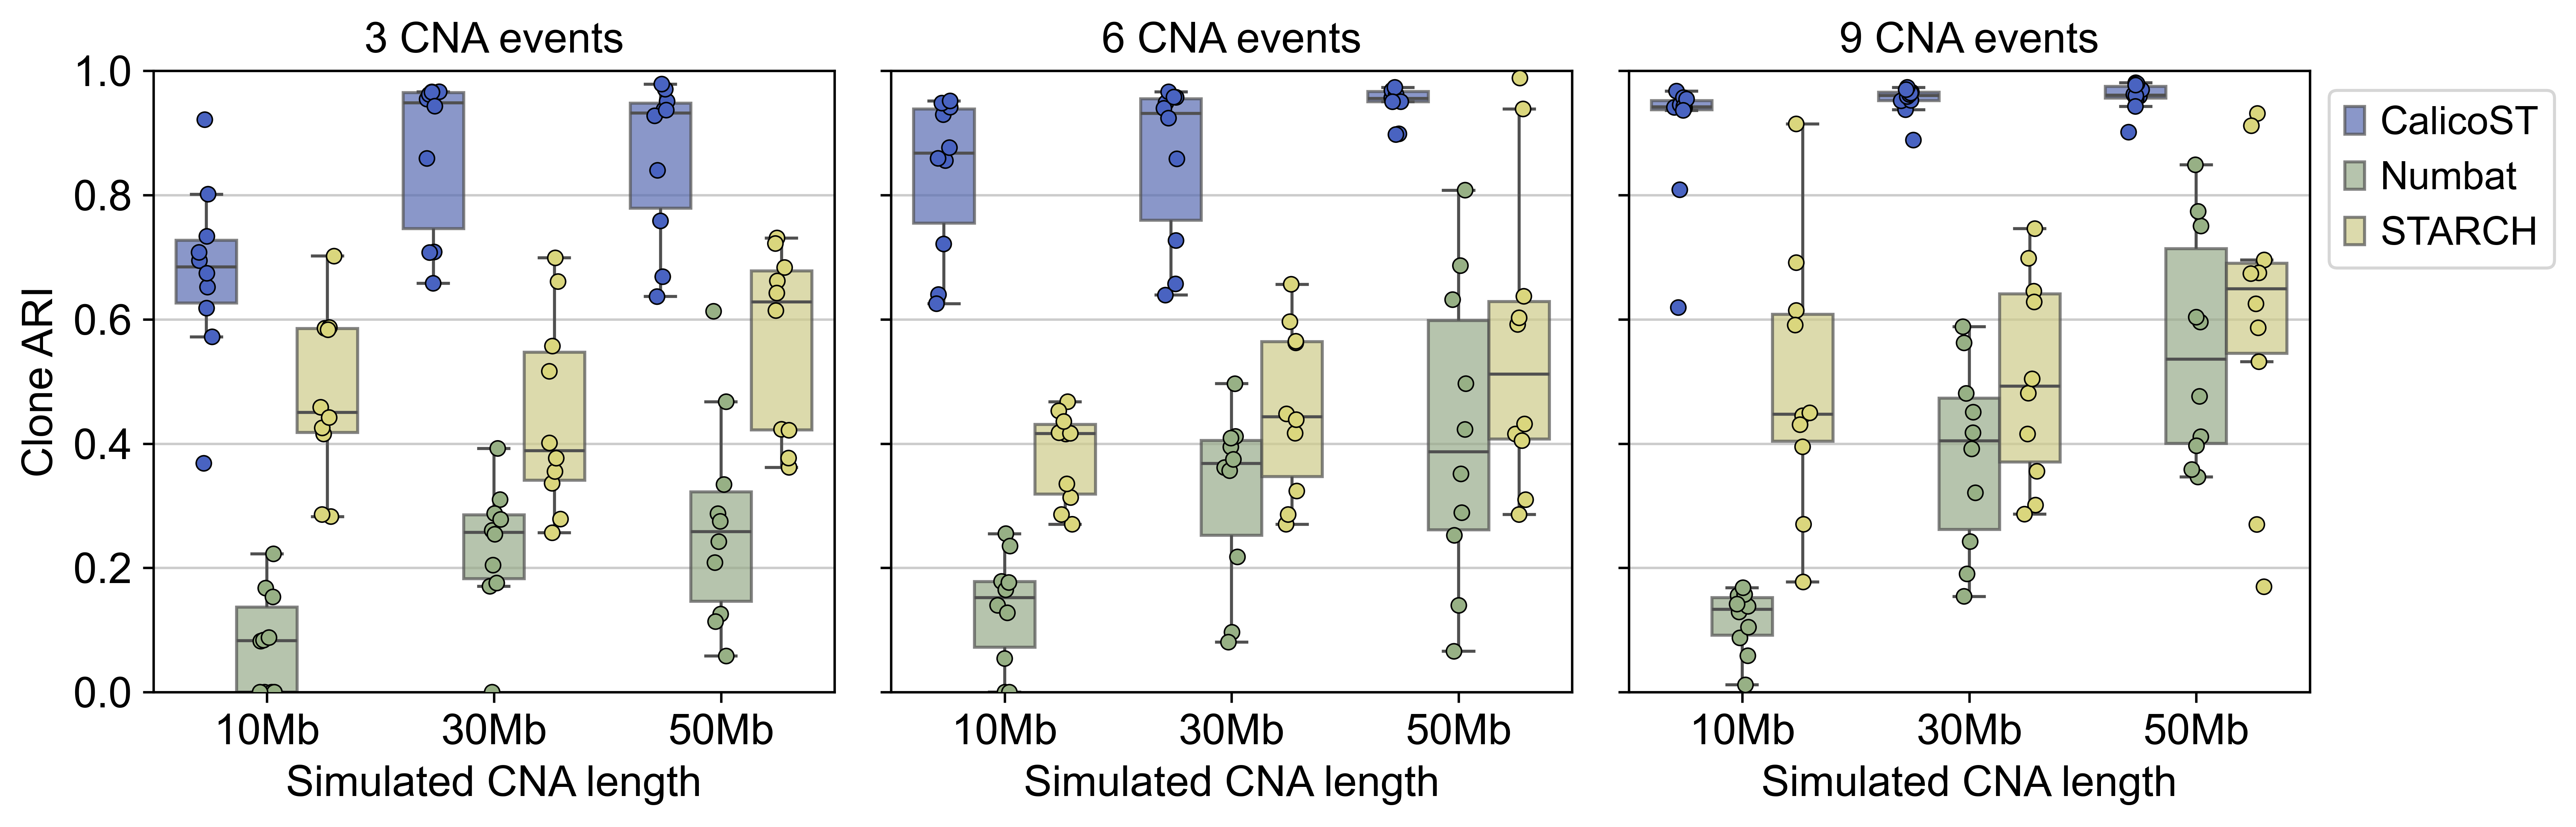

In [21]:
plot_aris(clone_aris)

# Event detection accuracy

The detection accuracy is evalated on a per-gene level:
the precision & sensitivity of genes involved in each category of event (Deletion, Amplication, LOH) for all events.

In [22]:
# NB (chr, start, end) for a given gene list.
df_hgtable = read_gene_loc(hg_table_file)
df_hgtable

,chr,start,end
name2,,,
FAM138A,1,34554,36081
OR4F5,1,65419,71585
AL627309.1,1,89295,133723
AL627309.3,1,89551,91105
AL627309.2,1,139790,140339
...,...,...,...
SHANK3,22,50674415,50733298
AC000036.1,22,50735825,50738139
ACR,22,50738196,50745339


In [31]:
df_event_f1 = get_f1s(true_dir, df_hgtable, calico_pure_dir, numbat_dir, starch_dir)
df_event_f1

,cnas,n_cnas,cna_size,random,ploidy,sample_id,method,event,F1,true_cna
0,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,DEL,0.378378,../simulated_data_related/numcnas1.2_cnasize1e...
1,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,AMP,0.115756,../simulated_data_related/numcnas1.2_cnasize1e...
2,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,CNLOH,0.790698,../simulated_data_related/numcnas1.2_cnasize1e...
3,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,overall,0.219251,../simulated_data_related/numcnas1.2_cnasize1e...
4,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,Numbat,DEL,0.000000,../simulated_data_related/numcnas1.2_cnasize1e...
...,...,...,...,...,...,...,...,...,...,...
1075,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,Numbat,overall,0.863992,../simulated_data_related/numcnas6.3_cnasize5e...
1076,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,STARCH,DEL,0.134228,../simulated_data_related/numcnas6.3_cnasize5e...
1077,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,STARCH,AMP,0.000000,../simulated_data_related/numcnas6.3_cnasize5e...
1078,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,STARCH,CNLOH,0.000000,../simulated_data_related/numcnas6.3_cnasize5e...


/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:811: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:817: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


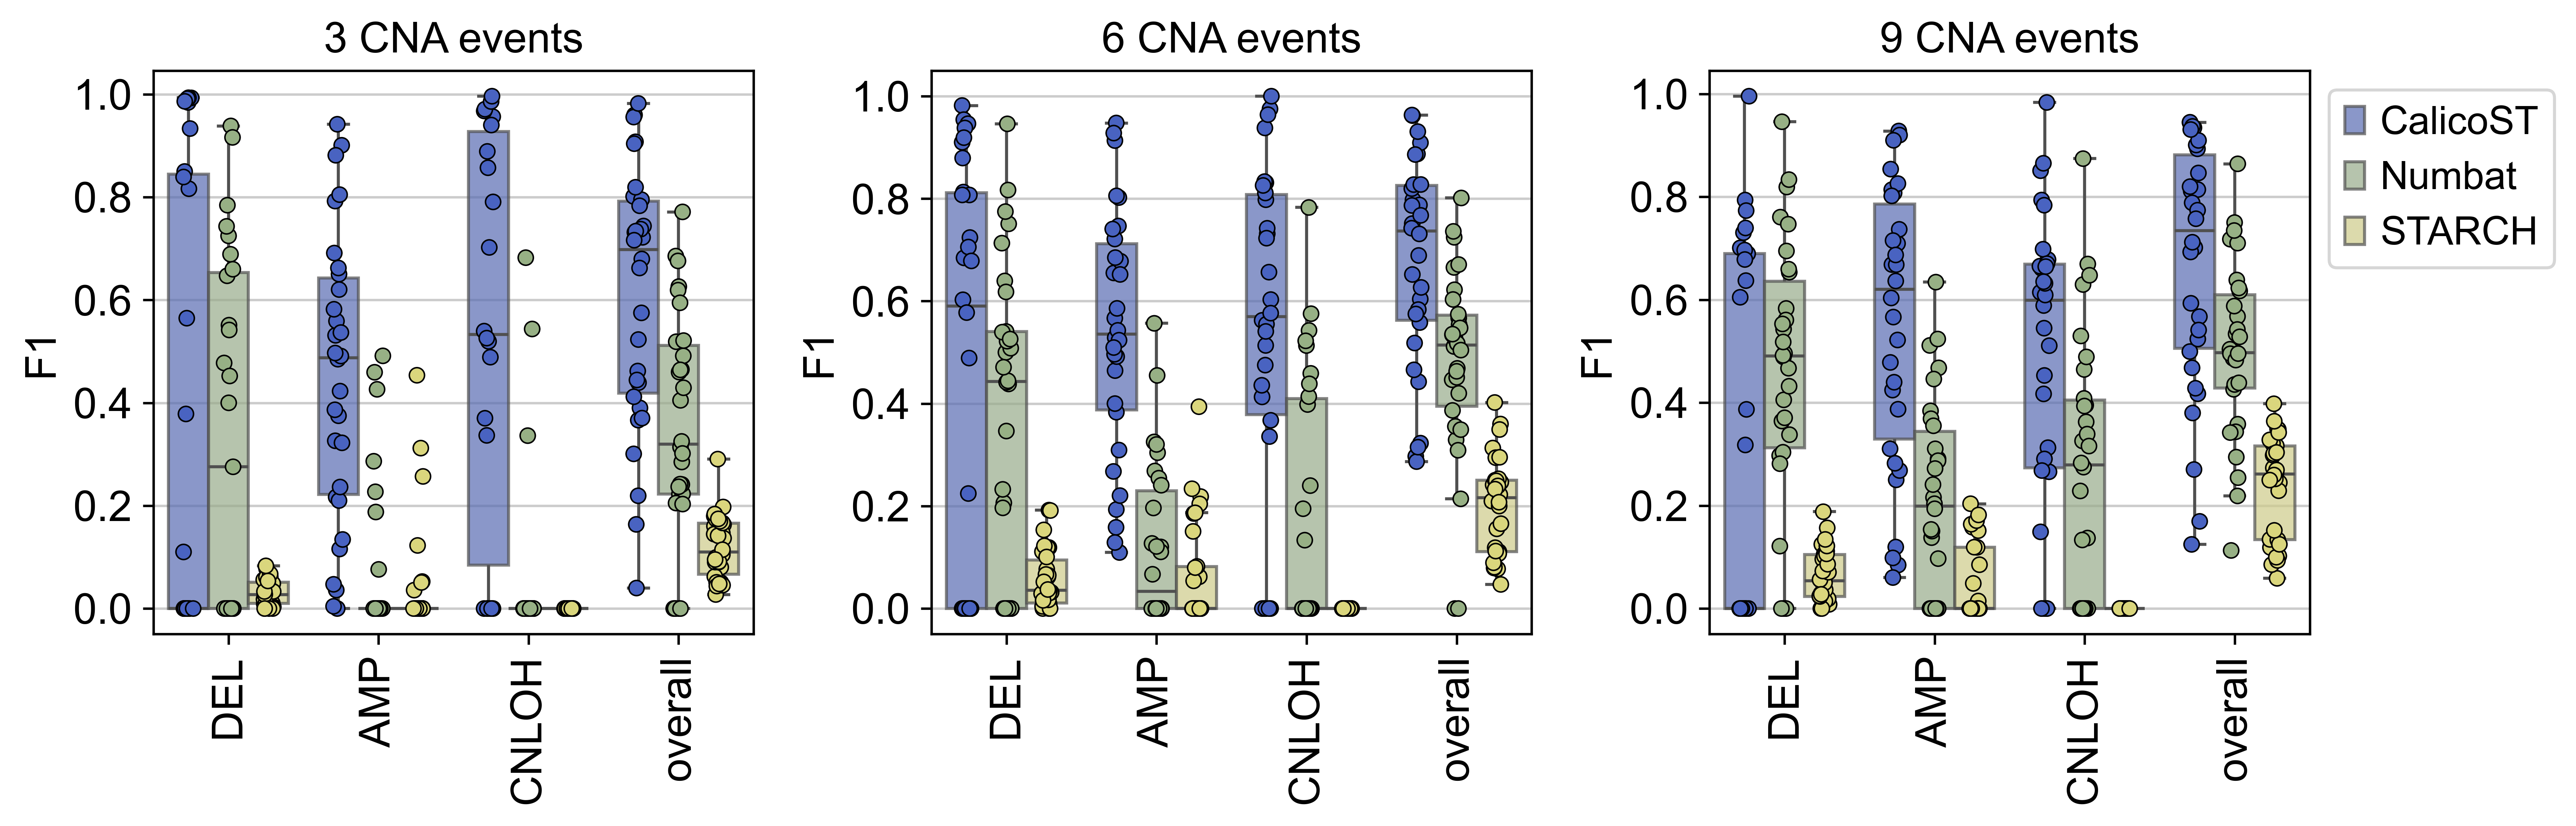

In [32]:
plot_f1s(df_event_f1)

# Done.